<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/BP_Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ABP and PPG signals from MIMIC-III waveform database.
(https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）


The output of this notebook is PPG signals with 5s segements at 125 Hz, with systolic and diastolic BP as numeric labels. The output data will be used to train a PPG_BP model in PPG_BP notebook.


The data cleaning and preprocessing is inspired by the following workflow, with some minor modification for our own application, where the order is:
1. Normalization
2. Segmentation
3. Flat line removal
4. Band-pass filter
5. Hampel filter

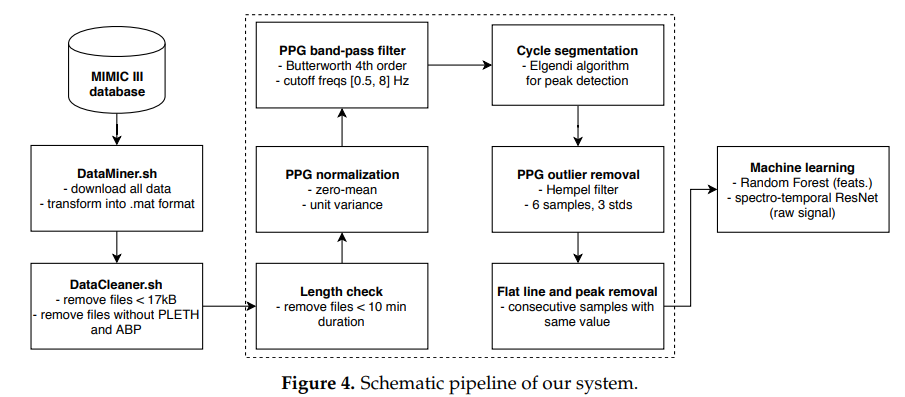

#2.Setup Environment

In [0]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import wfdb
import sklearn
from sklearn import preprocessing
import io
import pickle
import numba
from numba import jit
import tensorflow as tf
from scipy.signal import find_peaks

#3.Mine ABP and PPG data from WFDB

In [0]:
hd_names = []
for name in glob.glob("D:/WFDB//matched/*/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  363716 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ABP waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'ABP' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #only extract records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ABP and PPG with more than 10min recording')

with open('D:/WFDB//matched/BP/qualified_names.pkl', "wb") as fp:
  pickle.dump(qualified_names, fp)

There are total 54440 records that have both ABP and PPG with more than 10min recording


In [0]:
#qualified_names: from previous cell
#directory: directory to save the mined data
def mine_data(qualified_names, directory):
  ABP_signals = [] #create a  list to store all  ABP signals
  PPG_signals = [] #create a  list to store all  PPG signals
  n=0
  for name in qualified_names:
    record = wfdb.rdrecord(name)

    ABP_index = record.sig_name.index('ABP')
    PPG_index = record.sig_name.index('PLETH')
    ABP_sig = record.p_signal.T[ABP_index]
    PPG_sig = record.p_signal.T[PPG_index]

    if np.isnan(ABP_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
      continue
    else:
      ABP_signals.append(ABP_sig)
      PPG_signals.append(PPG_sig)
      n+=1
    
    #for every 500 samples, save to disk to release the RAM space
    if n%100 == 0:
      print("saving data No." + str(n//100))
      #save ABP data
      with open(directory + 'ABP_signals_'+str(n//100)+'.pkl', "wb") as fp:
        pickle.dump(ABP_signals, fp)
      #save PPG data
      with open(directory + 'PPG_signals_'+str(n//100)+'.pkl', "wb") as fp:
        pickle.dump(PPG_signals, fp)
      #clear up space in the list
      ABP_signals.clear()
      PPG_signals.clear()

    else:
      continue
  
  #save the last <100 ABP data
  with open(directory + 'ABP_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
    pickle.dump(ABP_signals, fp)
  #save the last <500 PPG data
  with open(directory + 'PPG_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
    pickle.dump(PPG_signals, fp)
  
  return None

In [0]:
directory = 'D:/WFDB//matched/BP/'
mine_data(qualified_names, directory)

#4.Process PPG and ABP raw data

In [0]:
with open('D:/WFDB//matched/BP/Original Data/PPG_signals_51.pkl', "rb") as fp:
  PPG_raw_signals = pickle.load(fp)

In [0]:
with open('D:/WFDB//matched/BP/Original Data/ABP_signals_51.pkl', "rb") as fp:
  ABP_raw_signals = pickle.load(fp)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


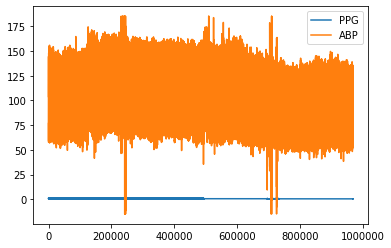

In [4]:
plt.plot(PPG_raw_signals[2],label="PPG")
plt.plot(ABP_raw_signals[2],label="ABP")
plt.legend()

##4.1 Flat line removal

To remove the flatline of a record: if 10% of the signals are made of flatline, then the entire record is removed. The flatline is defined as the change of consecutive points is smaller than a pre-defined threshold. In this notebook, the threshold has been set to 0, whereas a more reasonable value would come from histgram analysis of diff.


In [0]:
##flat_line: This function removes records that has flat_line region more than /
##            percentage of the record
##INPUT:
##      signals: raw PPG or ABP signals with dim (# of records, # of points)
##      threshold: threshold of the "change of consecutive points" to be defined/
##                 as flat point
##      percent: the the flat_line region is more than this percentage, the entire/
##                record will be removed
@jit(nopython=True)
def flat_line(signals,threshold = 0, percent = .10):
  clean_signals = []
  #create a list to store the index of the removed segments, this will be used
  #to remove the PPG signals with same index
  rm_list = []
  for i in range(len(signals)):
    #use np.diff to find consecutive points: diff = [i] - [i+1]
    signal_diff = np.diff(signals[i])
    #change value less than threshold to 0, and the rest to 1
    less = np.abs(signal_diff) <= threshold
    more = np.abs(signal_diff) > threshold
    signal_diff[less] = 0
    signal_diff[more] = 1
    #calculate what percent of 0 in the signal, remove the entire signal if 
    #percentage is higher than defined percent
    zero_per = np.sum(signal_diff==0)/len(signal_diff)
    if zero_per < percent:
      clean_signals.append(signals[i])
    else:
      rm_list.append(i)
    
    #track the progress for impatient programmer
    #if i%10000 == 0:
      #print("Processing on", i, "th sample")

  return clean_signals,rm_list

###4.1.1 PPG flat line removal

In [6]:
PPG_clean_signals,PPG_rm_list = flat_line(PPG_raw_signals,0,percent=0.10)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\numba\ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'signals' of function 'flat_line'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-33041893860a>", line 10:
@jit(nopython=True)
def flat_line(signals,threshold = 0, percent = .10):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [7]:
print('There are',len(PPG_clean_signals),'accepted PPG segments')
print('There are',len(PPG_rm_list),'rejected PPG segements that have flat line region more than ~10%')

There are 93 accepted PPG segments
There are 7 rejected PPG segements that have flat line region more than ~10%


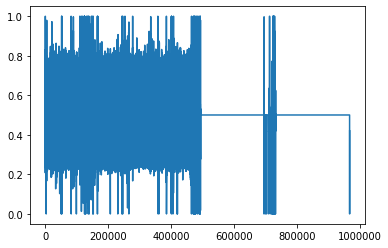

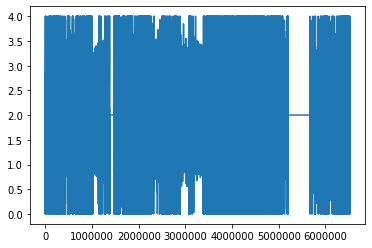

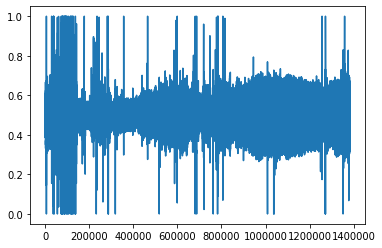

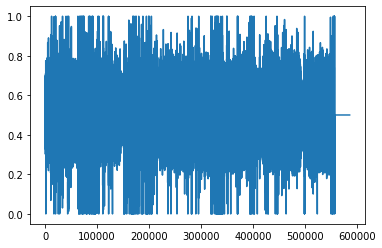

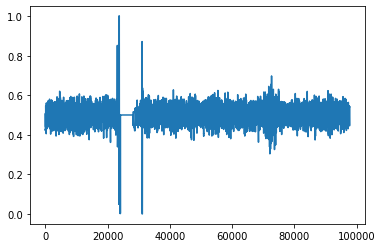

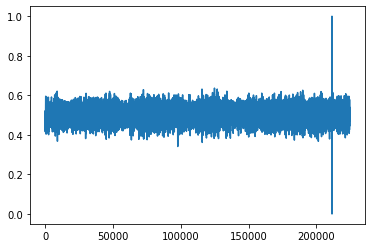

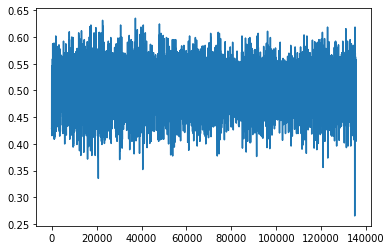

In [8]:
#take the fist 100 samples to see the rejected segements
for i in range(len(PPG_rm_list[:50])):
  x = PPG_rm_list[i]
  plt.figure()
  plt.plot(PPG_raw_signals[x])

###4.1.2 ABP flat line removal

In [0]:
ABP_clean_signals,ABP_rm_list = flat_line(ABP_raw_signals,0,percent=0.10)

In [10]:
print('There are',len(ABP_clean_signals),'accepted ABP segments')
print('There are',len(ABP_rm_list),'rejected ABP segements that have flat line region more than ~12%')

There are 92 accepted ABP segments
There are 8 rejected ABP segements that have flat line region more than ~12%


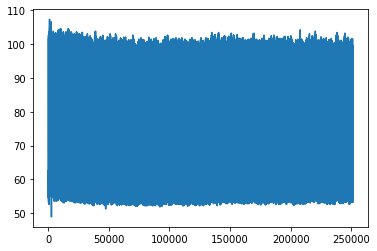

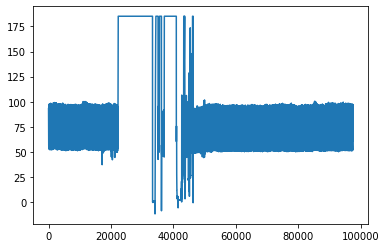

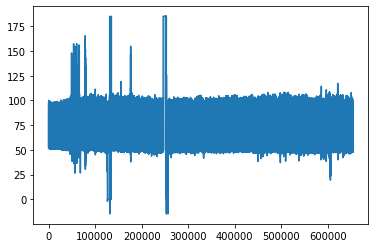

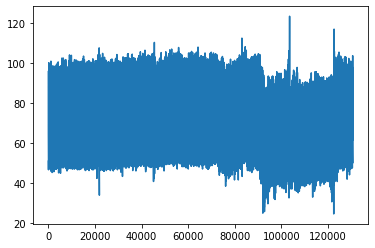

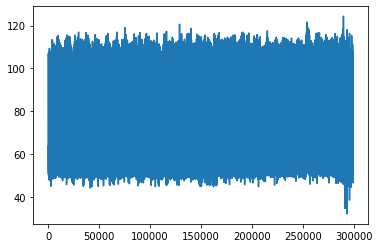

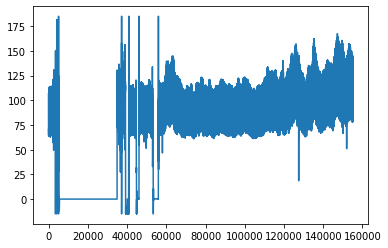

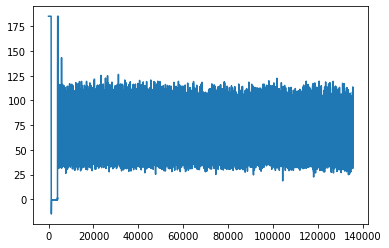

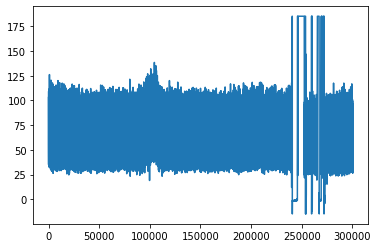

In [11]:
#take the fist 100 samples to see the rejected segements
for i in range(len(ABP_rm_list[:100])):
  x = ABP_rm_list[i]
  plt.figure()
  plt.plot(ABP_raw_signals[x])

###4.1.3 Remove flat ABP and PPG 


In [12]:
#join the two lists rm_list from ECG, and PPG_rm_list
ABP_list = pd.DataFrame(ABP_rm_list)
PPG_list = pd.DataFrame(PPG_rm_list)
try:
  total_list = ABP_list.merge(PPG_list,how="outer")
except:
  total_list = pd.concat([ABP_list,PPG_list],axis=0)
print('There are in total',len(total_list),"flat line segments in the joint list")

There are in total 14 flat line segments in the joint list


In [13]:
ABP_cl_signals = np.delete(ABP_raw_signals,total_list,0)
PPG_cl_signals = np.delete(PPG_raw_signals,total_list,0)
print('There are in total',len(ABP_cl_signals),"accepted ABP segments")
print('There are in total',len(PPG_cl_signals),"accepted PPG segments")

There are in total 86 accepted ABP segments
There are in total 86 accepted PPG segments


##4.2 Segmentation

###4.2.1 Turn records into 1min segs

In [0]:
#generate_segment_data: This function segement each record into a list of 1min signals
#input: 
#      source: records that have a flat line less than 10% or other predefined threshold
#      seg_len: the lenght of the output signal, for 125Hz sampling rate data, seg_len
#               is set to be 125 * 60 = 7500 for 1 min output
#output: a list of 1 mins signals from each records
def generate_segment_data(source,seg_len):
  signals =[]
  for signal in source:
    for i in range(int(len(signal)/seg_len)):
      seg = signal[seg_len*i:seg_len*(i+1)]
      signals.append(seg)
#convert list into a numpy array and change its dim from (num of records, seg_len, 1) to (num of records, seg_len)
  signals = np.asarray(list(map(lambda x: np.reshape(x,seg_len),signals)))

  return signals

In [15]:
ABP_seg_signals = generate_segment_data(ABP_cl_signals, 7500)
print('ABP segmented signals dim:', ABP_seg_signals.shape)

ABP segmented signals dim: (9376, 7500)


In [16]:
PPG_seg_signals = generate_segment_data(PPG_cl_signals, 7500)
print('PPG segmented signals dim:', PPG_seg_signals.shape)

PPG segmented signals dim: (9376, 7500)


###4.2.2 Apply flat_line on seg level

In [0]:
#lower tolerance for ABP since this will be used to generate ground truth
ABP_seg_clean_signals,ABP_seg_rm_list = flat_line(ABP_seg_signals,0,percent=0.02)

In [0]:
#higher tolerance for PPG since the DL algorithm needs to have some robustness
PPG_seg_clean_signals,PPG_seg_rm_list = flat_line(PPG_seg_signals,0,percent=0.05)

In [19]:
#join the two lists rm_list from ECG, and PPG_rm_list
ABP_seg_list = pd.DataFrame(ABP_seg_rm_list)
PPG_seg_list = pd.DataFrame(PPG_seg_rm_list)
try:
  total_seg_list = ABP_seg_list.merge(PPG_seg_list,how="outer")
except:
  total_seg_list = pd.concat([ABP_seg_list,PPG_seg_list],axis=0)
print('There are in total',len(total_seg_list),"flat line segments in the joint list")

There are in total 5673 flat line segments in the joint list


In [20]:
ABP_seg_cl_signals = np.delete(ABP_seg_signals,total_seg_list,0)
PPG_seg_cl_signals = np.delete(PPG_seg_signals,total_seg_list,0)
print('There are in total',len(ABP_seg_cl_signals),"accepted ABP segments")
print('There are in total',len(PPG_seg_cl_signals),"accepted PPG segments")

There are in total 3703 accepted ABP segments
There are in total 3703 accepted PPG segments


##4.3 Process ABP data

###4.3.1 Peak Segmentation

Do another segementation for ABP based on each peak (i.e. segement 1min signals into each heart beat cycle)



In [0]:
def peak_segmentation(signal,distance = 50):
  valleys, _ = find_peaks(signal*-1, distance=distance)
  
  segments = []
  for i in range(len(valleys)-1):
    seg = signal[valleys[i]:valleys[i+1]]
    segments.append(seg)
  
  return segments

In [138]:
ABP_ps_signals = [peak_segmentation(i) for i in ABP_seg_cl_signals]
print('ABP 1min segmented signals dim:', ABP_seg_cl_signals.shape)
print('ABP cycle segmented signals no. of samples:(',len(ABP_ps_signals),', No.of cycles, No.of points/cycle)')

ABP 1min segmented signals dim: (3703, 7500)
ABP cycle segmented signals no. of samples:( 3703 , No.of cycles, No.of points/cycle)


###4.3.2 Flat peak removal

In [0]:
#flat_peak: remove cycles that has flat peak in a 1min signal
#input: cycles: 1 min signals that consisits many heart beat cycles
#       tolerance: number of acceptable flat point 
#output: cleaned 1 min signals by removing flat peak cycles
def flat_peak(cycles, tolerance = 1):
  
  clean_cycles = []

  for i in range(len(cycles)):
    if len(np.argwhere(cycles[i] == np.amax(cycles[i]))) > tolerance:
      continue;
    else: 
      clean_cycles.append(cycles[i])

  return clean_cycles

In [0]:
#flat_peak_remove:remove 1min segements that has flat peak
#input: signals: A list of list (i.e. a list of 1 min signals that contains cyclic segments: ABP_ps_signals)
#       seg_ratio: threhold to remove the whole 1min signal (i.e. if the ratio of 
#                   "No. of cleaned flat peak cycles"/"No. of original 1min cycles" 
#                   is less than this treshold, then the whole 1min signal of cycles will be removed )
#output: cleaned_segments: a list of cleaned 1min signals
#        remova_index: a list of removed 1min signals
def flat_peak_remove(signals, seg_ratio = 0.95, tolerance = 1):

  clean_segments = []
  remove_index = [] 

  for i in range(len(signals)):
    #in case some lists are empty
    if signals[i] == []: 
      remove_index.append(i) 
      continue  

    clean_cycles = flat_peak(signals[i],tolerance)
    
    if len(clean_cycles)/(len(signals[i])) < seg_ratio: 
      remove_index.append(i)
      continue
    
    clean_segments.append(clean_cycles)

  return clean_segments, remove_index

In [0]:
ABP_fpr_signals, remove_index = flat_peak_remove(ABP_ps_signals,0.95,1)

In [142]:
print('ABP 1min segmented signals that has more than 10% cycles has flat peak:', len(remove_index))
print('Cleaned ABP 1min segmented signals:', len(ABP_fpr_signals))

ABP 1min segmented signals that has more than 10% cycles has flat peak: 3109
Cleaned ABP 1min segmented signals: 594


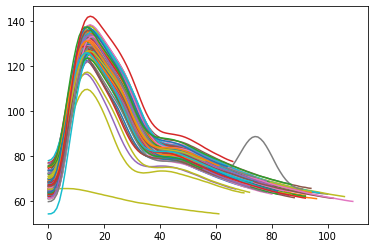

In [143]:
for i in range(len(ABP_ps_signals[remove_index[5]])):
  plt.figure
  plt.plot(ABP_ps_signals[remove_index[5]][i])

In [0]:
ABP_fpr_signals[1]

In [0]:
for i in range(len(ABP_fpr_signals[1])):
  plt.figure()
  plt.plot(ABP_fpr_signals[1][i])

###4.3.3 Remove PPG data

Remove PPG data that overlaps with ABP remove_index, since no ground truth BP value can be generated for those PPG data

In [104]:
PPG_fpr_signals = np.delete(PPG_seg_cl_signals,remove_index,0)
print('There are in total',len(ABP_fpr_signals),"accepted ABP 1min segments")
print('There are in total',len(PPG_fpr_signals),"accepted PPG 1min segments")

There are in total 1216 accepted ABP 1min segments
There are in total 1216 accepted PPG 1min segments


###4.3.4 Generate ground truth

In [0]:
#bp_ground_truth: A function that returns average systolic and diastolic value 
#                  of a 1min data
#Inputs: signals: ABP_fpr_signals
#      tolerance: acceptable fluctuations (max - min) of either systolic and diastolic \
#                 during a 1min measurement
#outputs: gt_ls: a list of ground truth for a list of 1min signals
#         remove_index: a list of 1 min signals that has either systolic or diastolic \
#                       fluctuation > tolerance mmHg
def bp_ground_truth(signals, tolerance = 10):
  gt_ls = []
  remove_index = []
  for i in range(len(signals)):
    cycles = signals[i]    #a list of cycles in 1min signal
    
    cyc_sys_list = []
    cyc_dia_list = []
    for j in range(len(cycles)):
      cyc_sys_list.append(max(cycles[j]))
      cyc_dia_list.append(cycles[j][0])

    if np.max(np.asarray(cyc_sys_list)) - np.min(np.asarray(cyc_sys_list)) > tolerance \
    or np.max(np.asarray(cyc_dia_list)) - np.min(np.asarray(cyc_dia_list)) > tolerance:
      remove_index.append(i)
      continue

    else: gt_ls.append([np.average(np.asarray(cyc_sys_list)),
                  np.average(np.asarray(cyc_dia_list))])

  return gt_ls, remove_index

In [107]:
gt_ls, gt_rm_ls = bp_ground_truth(ABP_fpr_signals, 30)
print("Ground truth list has", len(gt_ls), "samples")

Ground truth list has 651 samples


In [108]:
PPG_gt_signals = np.delete(PPG_fpr_signals,gt_rm_ls,0)
print('There are in total',len(gt_ls),"accepted ABP labels")
print('There are in total',len(PPG_gt_signals),"accepted PPG 1min segments")

There are in total 651 accepted ABP labels
There are in total 651 accepted PPG 1min segments


##4.4 Process PPG raw data
Only do scaling(standardization), bandpass and hempal on PPG signals, not on ABP, since APB's waveform will be the groundtruth for blood pressure.

###4.4.1 Scaling

In [0]:
#use robust_scale instead of scale to leave out outliers
PPG_norm_signals = [sklearn.preprocessing.robust_scale(i) for i in PPG_gt_signals]

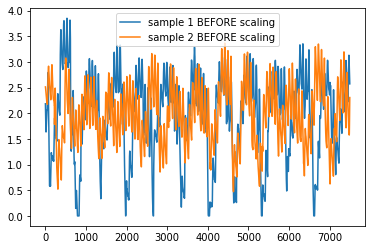

In [0]:
plt.plot(PPG_gt_signals[0],label="sample 1 BEFORE scaling")
plt.plot(PPG_gt_signals[10],label="sample 2 BEFORE scaling")
plt.legend()

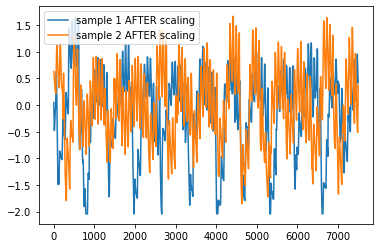

In [0]:
plt.plot(PPG_norm_signals[0],label="sample 1 AFTER scaling")
plt.plot(PPG_norm_signals[10],label="sample 2 AFTER scaling")
plt.legend()

###4.4.2 Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
PPG_bf_signals =[butter_bandpass_filter(i,0.5,8,300,order=4) for i in PPG_norm_signals]
print("After band pass filtering, there are:", len(PPG_bf_signals), "PPG records")

After band pass filtering, there are: 5214 PPG records


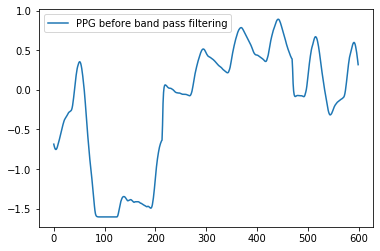

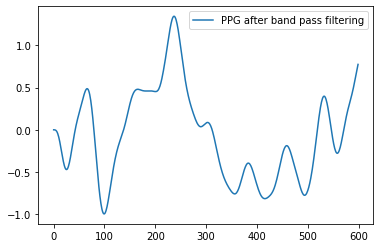

In [0]:
plt.plot(PPG_norm_signals[1][:600],label="PPG before band pass filtering")
plt.legend()
plt.figure()
plt.plot(PPG_bf_signals[1][:600], label="PPG after band pass filtering")
plt.legend()

###4.4.3 Hampel filter

The efffectiveness of hampel filter depends on how we play the two parameters: window_size and number of sigmas. 

In [0]:
#use numba to improve the speed of for loop
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    #indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            #indices.append(i)
    
    return new_series#, indices

In [0]:
PPG_hf_signals = [hampel_filter_forloop_numba(i, 6) for i in PPG_bf_signals]
print("After Hample filtering, there are:", len(PPG_hf_signals), "PPG segments")

After Hample filtering, there are: 5214 PPG segments


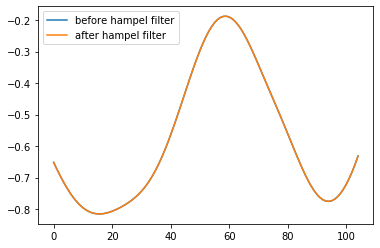

In [0]:
plt.plot(PPG_bf_signals[1][400:505], label = "before hampel filter")
plt.plot(PPG_hf_signals[1][400:505], label = "after hampel filter")
plt.legend()

# 5.Applied above steps to all data

In [0]:
  directory = 'D:/WFDB//matched/BP/Original Data/'

  ABP_names = glob.glob(directory + "ABP*.pkl")
  PPG_names = glob.glob(directory + "PPG*.pkl")

In [0]:
ABP_names[19]

'D:/WFDB//matched/BP/Original Data\\ABP_signals_116.pkl'

In [0]:
PPG_names[19]

'D:/WFDB//matched/BP/Original Data\\PPG_signals_116.pkl'

In [0]:
def process_data(directory):
  #load data
  ABP_names = glob.glob(directory + "Original Data/ABP*.pkl")
  PPG_names = glob.glob(directory + "Original Data/PPG*.pkl")
  assert(len(ABP_names) == len(PPG_names))
  for i in range(len(ABP_names)):
        
    print("processing", i, "th data")

    with open(ABP_names[i], "rb") as fp:
      ABP_raw_signals = pickle.load(fp)

    with open(PPG_names[i], "rb") as fp:
      PPG_raw_signals = pickle.load(fp)

    #remove flat lines on record level: ABP: 10%, PPG: 10%
    _, PPG_rm_list = flat_line(PPG_raw_signals,0,percent=0.10)
    _, ABP_rm_list = flat_line(ABP_raw_signals,0,percent=0.10)
    
    ABP_list = pd.DataFrame(ABP_rm_list)
    PPG_list = pd.DataFrame(PPG_rm_list)

    try:
      total_list = ABP_list.merge(PPG_list,how="outer")
    except:
      total_list = pd.concat([ABP_list,PPG_list],axis=0)
      
    removal_list=total_list.values.tolist()
    ABP_cl_signals = np.delete(ABP_raw_signals,total_list,0)
    PPG_cl_signals = np.delete(PPG_raw_signals,total_list,0)  

    #segment into 1min data
    ABP_seg_signals = generate_segment_data(ABP_cl_signals, 7500)
    PPG_seg_signals = generate_segment_data(PPG_cl_signals, 7500)

    #remove flat lines on 1min segment level: ABP: 2%, PPG: 5%
    _, ABP_seg_rm_list = flat_line(ABP_seg_signals,0,percent=0.02)
    _, PPG_seg_rm_list = flat_line(PPG_seg_signals,0,percent=0.05)

    ABP_seg_list = pd.DataFrame(ABP_seg_rm_list)
    PPG_seg_list = pd.DataFrame(PPG_seg_rm_list)

    try:
      total_seg_list = ABP_seg_list.merge(PPG_seg_list,how="outer")
    except:
      total_seg_list = pd.concat([ABP_seg_list,PPG_seg_list],axis=0)
    
    removal_list=total_list.values.tolist()
    ABP_seg_cl_signals = np.delete(ABP_seg_signals,total_seg_list,0)
    PPG_seg_cl_signals = np.delete(PPG_seg_signals,total_seg_list,0)

    #PROCESS ABP SIGNAL
    #1.peak segmentation: distance = 60
    ABP_ps_signals = [peak_segmentation(i, distance = 60) for i in ABP_seg_cl_signals]
    #2.flat peak removal: seg_ratio = 0.95, tolerance = 2
    ABP_fpr_signals, remove_index = flat_peak_remove(ABP_ps_signals,0.95,2)
    #3.remove corresponding PPG signal
    PPG_fpr_signals = np.delete(PPG_seg_cl_signals,remove_index,0)
    #4.generate ground truth ABP: tolerance = 30 mmHg
    gt_ls, gt_rm_list= bp_ground_truth(ABP_fpr_signals, tolerance=30)
    #5.remove corresponding PPG signals
    PPG_gt_signals = np.delete(PPG_fpr_signals,gt_rm_list,0)

    #PROCESS PPG SIGNAL
    #1.standardize PPG signal
    PPG_norm_signals = [sklearn.preprocessing.robust_scale(i) for i in PPG_gt_signals]
    #2.band pass filter on PPG sinal
    PPG_bf_signals =[butter_bandpass_filter(i,0.5,8,300,order=4) for i in PPG_norm_signals]
    #3. hampel filter
    PPG_hf_signals = [hampel_filter_forloop_numba(i, 6) for i in PPG_bf_signals]
    #4. resample signal
    ##PLACEHOLDER for resampling signal to a lower frequency, if needed
    with open(directory + "BP_data" + "_" + str(i), "wb") as fp:
      pickle.dump(PPG_hf_signals,fp)

    with open(directory + "BP_label" + "_" + str(i), "wb") as fp:
      pickle.dump(gt_ls,fp)

  return None

In [0]:
directory = 'D:/WFDB//matched/BP/'
process_data(directory)

In [0]:
with open('D:/WFDB//matched/BP/BP_data.pkl', "wb") as fp:
  pickle.dump(PPG_hf_signals,fp)

with open('D:/WFDB//matched/BP/BP_label.pkl', "wb") as fp:
  pickle.dump(gt_ls,fp)